In [148]:
import numpy as np
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn import model_selection
#from sklearn import cross_validation
from collections import Counter

In [149]:
#data reading
con = sqlite3.connect('database.sqlite')

# neglect the review having the score=3
filtered_data = pd.read_sql_query('''SELECT * FROM Reviews WHERE Score != 3''',con)

def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition)
filtered_data['Score'] = positiveNegative

In [150]:
filtered_data.shape

(525814, 10)

In [151]:
filtered_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [152]:
filtered_data['Score'].value_counts()

positive    443777
negative     82037
Name: Score, dtype: int64

In [153]:
#EDA
display = pd.read_sql_query('''
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
''',con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


In [154]:
sorted_data = filtered_data.sort_values('ProductId',axis=0 , ascending=True, inplace=False, kind='quicksort', na_position='last')

In [155]:
final= sorted_data.drop_duplicates(subset={'UserId', 'ProfileName', 'Time', 'Text'}, keep='first', inplace=False)
final.shape

(364173, 10)

In [156]:
#after removing duplications we will see how much percent of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

In [157]:
display= pd.read_sql_query('''SELECT * FROM Reviews WHERE Score!=3 AND Id=44737 OR Id=64422
ORDER BY ProductId''',con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [158]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [159]:
print(final.shape)

(364171, 10)


In [160]:
print(final['Score'].value_counts())

positive    307061
negative     57110
Name: Score, dtype: int64


In [161]:
#preprocessing like removal of stop words,html tags and make all letters in lowercase.
import re
i=0;
for sent in final['Text'].values:
    if(len(re.findall('<.*?>',sent))):
        print(i)
        print(sent)
        break;
    i+=1;    

6
I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


In [162]:
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
import nltk

stop= set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initializing snowball stemmer

def cleanhtml(sentence): #function to clean word of any html tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr,'',sentence)
    return cleantext
def cleanpunc(sentence): #function to clean word of any punctuation or special character
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return cleaned
print(stop)
print('#######################################################################')
print(sno.stem('tasty'))


{'him', 'until', 'very', 'been', 'when', 'mightn', 'up', "you'd", 'not', 'some', 'd', 'myself', 'through', 'just', 'hers', 'is', 'am', 'any', 'ain', 'against', 'he', 'hasn', 're', 'same', "won't", 'them', 'other', 'shouldn', 'did', "hasn't", 'no', 'you', 'a', 'will', 'yours', 'now', 'of', 'again', 'they', 'y', 'below', 'where', 'll', 'between', "weren't", 'few', 'this', 'with', 'above', 'the', 'doing', 'itself', 's', 'don', 'do', 'off', 'have', 'out', 'yourself', 'being', 'such', 'can', 'aren', 'these', 'that', "don't", "mightn't", 'we', 'what', 'too', 'once', "hadn't", 'she', 'but', 'i', 'most', "should've", "you'll", "couldn't", 'which', "aren't", "mustn't", 've', 'are', 'at', 'before', "shan't", 'how', "shouldn't", 'm', 'after', 'herself', 'wasn', 'weren', 'who', "didn't", 'under', 'than', 'me', 'haven', 'won', 'were', 'why', "doesn't", "it's", 'having', 'didn', 'needn', 'while', 'further', 'then', "wouldn't", 'there', "you've", 'an', 'for', 'theirs', 'into', 'each', 'because', "she

In [163]:
#code for implementing step by step the checks mentioned in the pre-processing phase
i=0
str1=' '
final_string=[]
all_positive_words=[] #store words from positive reviews here
all_negative_words=[] #store words from negative reviews here
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) #remove HTML tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive':
                        all_positive_words.append(s)
                    if (final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s)
                else:
                    continue
            else:
                continue
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************")
    
    final_string.append(str1)
    i=+1
                    
            
            
    
    

In [164]:
final['CleanedText']=final_string #adding a column of cleanedtext which display the data after preprocessingof the review

In [165]:
final.head(3) #below the processed review can be seen in the cleanedtext column

#store final table into an sqlite table for future
conn=sqlite3.connect('final.sqlite')
c=conn.cursor()
conn.text_factory = str
final.to_sql('Reviews',conn,schema=None,if_exists='replace',index=True,index_label=None,dtype=None)


In [166]:
import sqlite3
con = sqlite3.connect('final.sqlite')

In [167]:
cleaned_data = pd.read_sql_query('select * from reviews',con)

In [168]:
cleaned_data.shape

(364171, 12)

In [169]:
#to randomly sample 5k points from both class
data_p = cleaned_data[cleaned_data['Score']== 'positive'].sample(n = 5000)
data_n = cleaned_data[cleaned_data['Score']== 'negative'].sample(n = 5000)
final_10k = pd.concat([data_p, data_n])
final_10k.shape

(10000, 12)

In [170]:
#sorting data based on time
final_10k['Time'] = pd.to_datetime(final_10k['Time'], unit='s')
final_10k = final_10k.sort_values(by='Time')

In [171]:
#BOW
#function to compute K value
def k_classifier_brute(x_train, y_train):
    #creating odd list of k for knn
    myList =list(range(0,40))
    neighbors = list(filter(lambda x: x %2 != 0,myList))
    
    #empty lists that will hold cv scores
    cv_scores = []
    
    #perform 10 fold cross validation 
    for k in neighbors:
        knn = KNeighborsClassifier(n_neighbors=k, algorithm = "brute")
        scores = cross_val_score(knn, x_train, y_train, cv=10, scoring='accuracy')
        cv_scores.append(scores.mean())
        
    #changing to misclassification error
    MSE = [1-x for x in cv_scores]
    
    #determining best k
    optimal_k = neighbors[MSE.index(min(MSE))]
    print('\nThe optimal number of neighbors is %d.' % optimal_k)
    
    #plot misclassification error vs k
    plt.plot(neighbors , MSE)
    
    for xy in zip(neighbors, np.round(MSE,3)):
        plt.annotate(('%s, %s') %xy, xy=xy, textcoords='data')
    plt.title("Mislassification Error vs k")
    plt.xlabel('Number of neighbors k')
    plt.ylabel('Misclassification Error')
    plt.show()
    
    print("the misclassification error for each k value is:", np.round(MSE,3))
    return optimal_k
    
    

In [172]:
#7k data which will use to train model after vectorization
x = final_10k['CleanedText']
print('shape of x:', x.shape)

shape of x: (10000,)


In [173]:
#cass label
y = final_10k['Score']
print('shape of y:', y.shape)

shape of y: (10000,)


In [174]:
#splitting data into 70% as train 30% as test data
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = (train_test_split(x, y, test_size = 0.3, random_state = 42))
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(7000,) (3000,) (7000,) (3000,)


In [175]:
#train vectorizer
from sklearn.feature_extraction.text import CountVectorizer

bow = CountVectorizer()
x_train = bow.fit_transform(x_train)
x_train

<7000x11909 sparse matrix of type '<class 'numpy.int64'>'
	with 226384 stored elements in Compressed Sparse Row format>

In [176]:
#test vectorizer
x_test = bow.transform(x_test)

In [177]:
x_test.shape

(3000, 11909)


The optimal number of neighbors is 19.


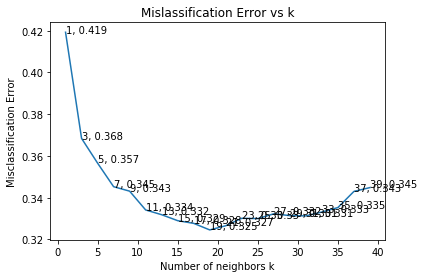

the misclassification error for each k value is: [0.419 0.368 0.357 0.345 0.343 0.334 0.332 0.329 0.328 0.325 0.327 0.33
 0.33  0.332 0.331 0.331 0.333 0.335 0.343 0.345]


19

In [178]:
#to chosse optimal_k using brute force algorithm

from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import model_selection
#from sklearn import cross_validation not working
optimal_K_bow = k_classifier_brute(x_train, y_train)

optimal_K_bow

In [179]:
#instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_K_bow)

#fitting the model
knn_optimal.fit(x_train, y_train)
#knn_optimal.fit(bow_data,y_train)

#predict the response
pred = knn_optimal.predict(x_test)


In [180]:
#accuracy on train data
train_acc_bow = knn_optimal.score(x_train, y_train)
print("Train accuracy", train_acc_bow)

Train accuracy 0.7345714285714285


In [181]:
#error on train data
train_err_bow = 1-train_acc_bow
print("Train Error %f%%" % (train_err_bow))

Train Error 0.265429%


In [182]:
#evaluate accuracy on test data
acc_bow = accuracy_score(y_test,pred)*100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' %(optimal_K_bow, acc_bow))


The accuracy of the knn classifier for k = 19 is 68.200000%


In [183]:
#comfusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pred)
cm

array([[ 863,  640],
       [ 314, 1183]], dtype=int64)

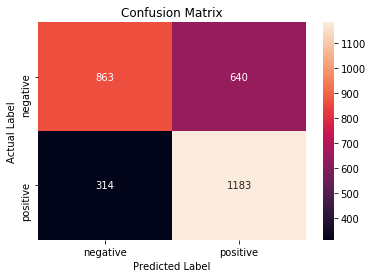

In [184]:
#plot confusion matrix to describe the perfomance of classifier

import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.show()

In [185]:
#to show main classifier report
from sklearn.metrics import classification_report
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

    negative       0.73      0.57      0.64      1503
    positive       0.65      0.79      0.71      1497

    accuracy                           0.68      3000
   macro avg       0.69      0.68      0.68      3000
weighted avg       0.69      0.68      0.68      3000



In [186]:
#Tf-IDF
#data
x = final_10k['CleanedText']

In [187]:
#Target/class-label
y = final_10k['Score']

In [188]:
#split data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 42)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(7000,) (3000,) (7000,) (3000,)


In [189]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
x_train = tf_idf_vect.fit_transform(x_train)
x_train

<7000x186100 sparse matrix of type '<class 'numpy.float64'>'
	with 491336 stored elements in Compressed Sparse Row format>

In [190]:
#convert test text data to its vectorizer
x_test = tf_idf_vect.transform(x_test)
x_test.shape

(3000, 186100)


The optimal number of neighbors is 39.


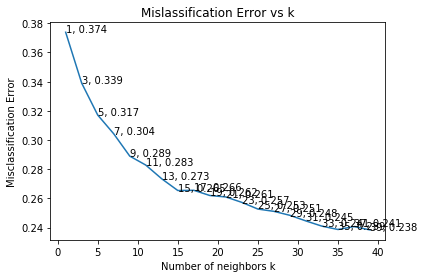

the misclassification error for each k value is: [0.374 0.339 0.317 0.304 0.289 0.283 0.273 0.265 0.266 0.262 0.261 0.257
 0.253 0.251 0.248 0.245 0.241 0.239 0.241 0.238]


39

In [191]:
#to choosing optimal k
optimal_k_tfidf = k_classifier_brute(x_train, y_train)
optimal_k_tfidf

In [192]:
#instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k_tfidf)

#fitting the model
knn_optimal.fit(x_train, y_train)

#predict the response
pred = knn_optimal.predict(x_test)

In [193]:
#accuracy on train data
train_acc_tfidf = knn_optimal.score(x_train, y_train)
print("Train accuracy", train_acc_tfidf)

Train accuracy 0.7887142857142857


In [194]:
#error on train data
train_err_tfidf = 1-train_acc_tfidf
print("Train Error %f%%" % (train_err_tfidf))

Train Error 0.211286%


In [195]:
#evaluate accuracy
acc_tfidf = accuracy_score(y_test, pred) * 100
print('n\The accuracy of the knn classifier for k = %d is %f%%' % (optimal_k_tfidf, acc_tfidf))

n\The accuracy of the knn classifier for k = 39 is 76.400000%


In [196]:
#from sklearn.matrics import confusion_matrix
cm = confusion_matrix(y_test, pred)
cm

array([[1119,  384],
       [ 324, 1173]], dtype=int64)

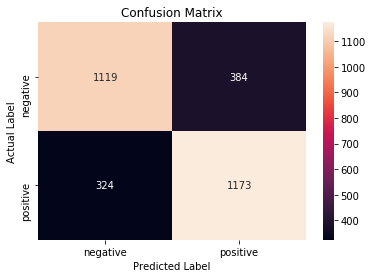

In [197]:
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.show()

In [198]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

    negative       0.78      0.74      0.76      1503
    positive       0.75      0.78      0.77      1497

    accuracy                           0.76      3000
   macro avg       0.76      0.76      0.76      3000
weighted avg       0.76      0.76      0.76      3000



In [199]:
#W2V
#data
x = final_10k['Text']
x.shape

(10000,)

In [200]:
#Target/ class-label
y = final_10k['Score']
y.shape

(10000,)

In [201]:
x_train, x_test, y_train, y_test = train_test_split(x, y,test_size = 0.3)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(7000,) (3000,) (7000,) (3000,)


In [202]:
import re

def cleanhtml(sentence): #function to clean the word of any html_tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]', r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]', r'',cleaned)
    return cleaned
    

In [203]:
#train own word2vec model using your own train text corpus
import gensim
list_of_sent=[]
for sent in x_train:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue
    list_of_sent.append(filtered_sentence)            

In [204]:
w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

In [205]:
w2v_model.wv.most_similar('like')

[('enjoy', 0.7429904937744141),
 ('think', 0.7078890800476074),
 ('horrible', 0.6947021484375),
 ('prefer', 0.6804286241531372),
 ('actually', 0.6739835739135742),
 ('smell', 0.673389196395874),
 ('nasty', 0.6667637825012207),
 ('awful', 0.6588493585586548),
 ('mean', 0.6572538018226624),
 ('detect', 0.6540613174438477)]

In [206]:
w2v = w2v_model[w2v_model.wv.vocab]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


In [207]:
w2v.shape

(5353, 50)

In [208]:
#train your own word2vec model using your own test text corpus
import gensim
list_of_sent_test = []
for sent in x_test:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue
    list_of_sent_test.append(filtered_sentence)            

In [209]:
w2v_model=gensim.models.Word2Vec(list_of_sent_test, min_count=5, size=50, workers=4)

In [210]:
w2v_model.wv.most_similar('like')

[('really', 0.9674217700958252),
 ('taste', 0.965744137763977),
 ('but', 0.9520599842071533),
 ('good', 0.9324131011962891),
 ('not', 0.9289782643318176),
 ('much', 0.9252222776412964),
 ('does', 0.9204928874969482),
 ('tastes', 0.9121184349060059),
 ('its', 0.9090662002563477),
 ('just', 0.9025527834892273)]

In [211]:
w2v = w2v_model[w2v_model.wv.vocab]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


In [212]:
w2v.shape

(3243, 50)

In [213]:
#avg w2v
#compute average word2vec for each review.
sent_vectors = []; #the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: #for each review/sentence
    sent_vec = np.zeros(50) #as word vectirs are of zero length
    cnt_words = 0; #number of word with a valid vectorin the sentence/review
    for word in sent: #for each word in a review or sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))


7000
50


In [214]:
sent_vectors_test = [];
for sent in list_of_sent_test:
    sent_vec = np.zeros(50)
    cnt_words = 0;
    for word in sent:
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))


3000
50


In [215]:
x_train = sent_vectors

In [216]:
x_test = sent_vectors_test


In [217]:
x_test = np.nan_to_num(x_test)


The optimal number of neighbors is 37.


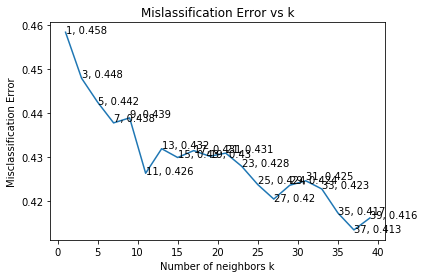

the misclassification error for each k value is: [0.458 0.448 0.442 0.438 0.439 0.426 0.432 0.43  0.431 0.43  0.431 0.428
 0.424 0.42  0.424 0.425 0.423 0.417 0.413 0.416]


37

In [218]:
optimal_k_avgw2v = k_classifier_brute(x_train, y_train)
optimal_k_avgw2v

In [219]:
#instantiate learnig model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k_avgw2v)

#fitting the model
knn_optimal.fit(x_train, y_train)
#knn_optimal.fit(bow_data, y_train)

#predict the response
pred = knn_optimal.predict(x_test)

In [220]:
#accuracy on train data
train_acc_avgw2v = knn_optimal.score(x_train, y_train)
print("Train accuracy", train_acc_avgw2v)

Train accuracy 0.6268571428571429


In [221]:
#error on train data
train_err_avgw2v = 1-train_acc_avgw2v
print("Train Error %f%%" %(train_err_avgw2v))

Train Error 0.373143%


In [222]:
#evaluate accuracy
acc_avg_w2v = accuracy_score(y_test, pred)* 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' %(optimal_k_avgw2v, acc_avg_w2v))


The accuracy of the knn classifier for k = 37 is 58.533333%


In [223]:
print("Test Error %f%%" %(100-(acc_avg_w2v)))

Test Error 41.466667%


In [224]:
cm = confusion_matrix(y_test, pred)
cm

array([[978, 544],
       [700, 778]], dtype=int64)

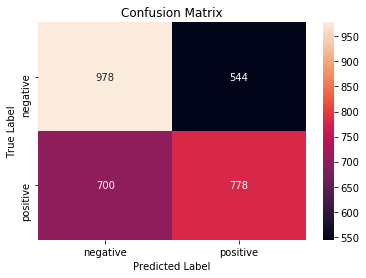

In [225]:
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [226]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

    negative       0.58      0.64      0.61      1522
    positive       0.59      0.53      0.56      1478

    accuracy                           0.59      3000
   macro avg       0.59      0.58      0.58      3000
weighted avg       0.59      0.59      0.58      3000



In [227]:
#Tf-idf weighted word2vec
tfidf_feat = tf_idf_vect.get_feature_names()  #tfidf words/col-names
#final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val=tfidf

tfidf_sent_vectors = []; #the tfidf-w2v for each sentence/review is stored in the list
row=0;
for sent in list_of_sent:
    sent_vec = np.zeros(50) #as word vectors are of zero length
    weighted_sum = 0; #num of words with a valid vector in the sentence/review
    for word in sent:
        try:
            vec = w2v_model.wv[word]
            #obtain the tfidf of a word in a sentence/review
            tfidf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weighted_sum += tf_idf
        except:
            pass
    sent_vec /= weighted_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1
        


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


In [228]:
len(tfidf_sent_vectors)

7000

In [229]:
x_train = tfidf_sent_vectors

In [230]:
#Tf-idf weighted word2vec
tfidf_feat = tf_idf_vect.get_feature_names()  #tfidf words/col-names
#final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val=tfidf

tfidf_sent_vectors_test = []; #the tfidf-w2v for each sentence/review is stored in the list
row=0;
for sent in list_of_sent_test:
    sent_vec = np.zeros(50) #as word vectors are of zero length
    weighted_sum = 0; #num of words with a valid vector in the sentence/review
    for word in sent:
        try:
            vec = w2v_model.wv[word]
            #obtain the tfidf of a word in a sentence/review
            tfidf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weighted_sum += tf_idf
        except:
            pass
    sent_vec /= weighted_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


In [231]:
len(tfidf_sent_vectors_test)

3000

In [232]:
x_test = tfidf_sent_vectors_test

In [233]:
x_train = np.nan_to_num(x_train)
x_test = np.nan_to_num(x_test)


The optimal number of neighbors is 3.


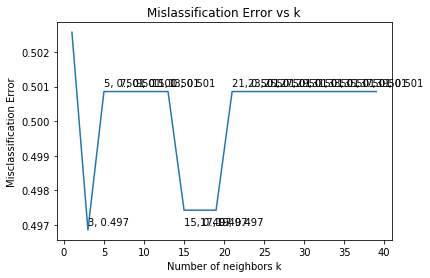

the misclassification error for each k value is: [0.503 0.497 0.501 0.501 0.501 0.501 0.501 0.497 0.497 0.497 0.501 0.501
 0.501 0.501 0.501 0.501 0.501 0.501 0.501 0.501]


3

In [234]:
optimal_k_tfidf_w2v = k_classifier_brute(x_train, y_train)
optimal_k_tfidf_w2v

In [235]:
#instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k_tfidf_w2v)

#fitting the model
knn_optimal.fit(x_train, y_train)

#predict the response
pred = knn_optimal.predict(x_test)

In [236]:
#accuracy on train data
train_acc_tfidf_w2v = knn_optimal.score(x_train, y_train)
print("Train accuracy", train_acc_tfidf_w2v)

Train accuracy 0.49685714285714283


In [237]:
#Error on train data
train_err_tfidf_w2v = 1-train_acc_tfidf_w2v
print("Train Error %f%%" % (train_err_tfidf_w2v))

Train Error 0.503143%


In [238]:
#evaluate accuracy
acc_tfidf_w2v = accuracy_score(y_test, pred) *100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' %(optimal_k_tfidf_w2v, acc_tfidf_w2v))



The accuracy of the knn classifier for k = 3 is 50.733333%


In [239]:
print("Test Error %f%%" %(100-(acc_tfidf_w2v)))

Test Error 49.266667%


In [240]:
cm = confusion_matrix(y_test, pred)
cm

array([[1522,    0],
       [1478,    0]], dtype=int64)

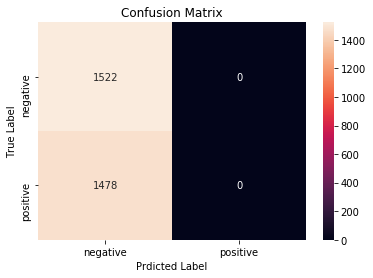

In [241]:
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Prdicted Label")
plt.ylabel("True Label")
plt.show()

In [242]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

    negative       0.51      1.00      0.67      1522
    positive       0.00      0.00      0.00      1478

    accuracy                           0.51      3000
   macro avg       0.25      0.50      0.34      3000
weighted avg       0.26      0.51      0.34      3000



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [243]:
#model
models = pd.DataFrame({'Model':['KNN with BOW', "KNN with TFIDF", "KNN with Avg_w2v", "KNN with tfidf_w2v"],
                       'Hyper Parameter(k)': [optimal_K_bow,optimal_k_tfidf,optimal_k_avgw2v,optimal_k_tfidf_w2v],
                      'Train Error': [train_err_bow, train_err_tfidf, train_err_avgw2v, train_err_tfidf_w2v],
                      'Test Error': [100-acc_bow, 100-acc_tfidf, 100-acc_avg_w2v, 100-acc_tfidf_w2v],
                      'Accuracy':[acc_bow, acc_tfidf, acc_avg_w2v, acc_tfidf_w2v]},
                     columns = ["Model", "Hyper Parameter(k)", "Train Error", "Test Error", "Accuracy"])
models.sort_values(by='Accuracy', ascending=False)

,Model,Hyper Parameter(k),Train Error,Test Error,Accuracy
1,KNN with TFIDF,39,0.211286,23.600000,76.400000
0,KNN with BOW,19,0.265429,31.800000,68.200000
2,KNN with Avg_w2v,37,0.373143,41.466667,58.533333
3,KNN with tfidf_w2v,3,0.503143,49.266667,50.733333
